# Exercise 1

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# from matplotlib.animation import FuncAnimation

1.2: Time Dependent Diffusion Equation

Stability: False


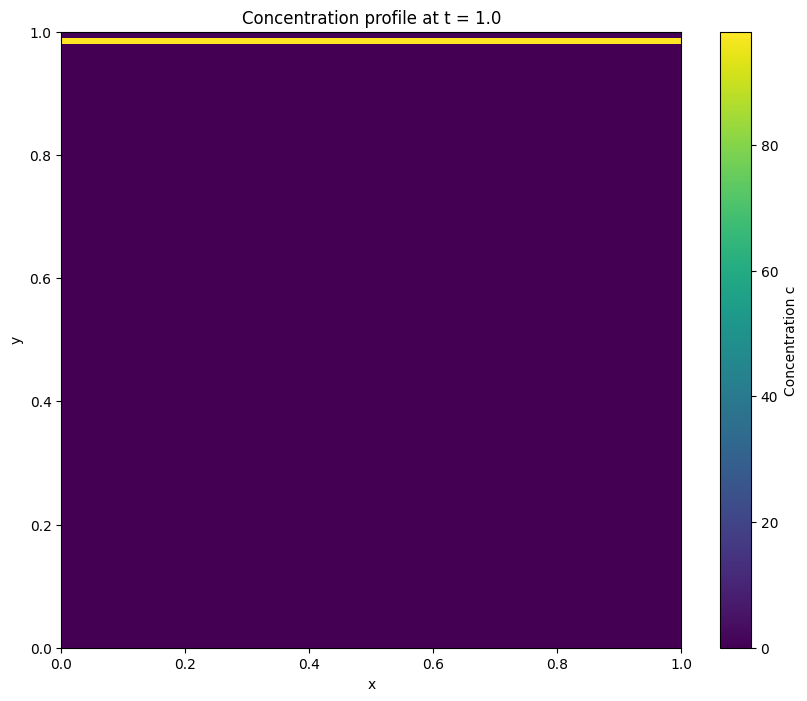

In [36]:
# Parameters
D = 1.0  # diffusion coefficient
Lx, Ly = 1.0, 1.0   # domain size
Nx, Ny = 100, 100   # number of points in the x and y directions
dx = Lx / (Nx - 1)  # spatial resolution in x
dy = Ly / (Ny - 1)  # spatial resolution in y
dt = 0.01          # size of time step
T = 1.0             # total simulation time
Nt = int(T / dt)    # total number of time steps

# Stability condition 
check_stable = (4*dt*D) / dt**2
print(f"Stability: {check_stable <= 1}")

# Initial condition: c(x, y; t=0) = 0 
c = np.zeros((Ny, Nx))
c[-1, :] = 1.0  # setting top boundary condition c(x, y=1; t) = 1

# Time evolution
for n in range(1, Nt + 1):
    c_new = c.copy()
    for i in range(1, Ny-1):
        for j in range(1, Nx-1):
            c_new[i, j] = c[i, j] + D * dt * (
                (c[i+1, j] + c[i-1, j] + c[i-1, j+1]) - 4*c[i,j] )/ dx**2               
    
    # Periodic boundary conditions in x-direction
    c_new[:, 0] = c_new[:, -2]
    c_new[:, -1] = c_new[:, 1]
    


plt.figure(figsize=(10, 8))
plt.imshow(c_new, extent=[0, Lx, 0, Ly], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Concentration c')
# plt.plot(c_new)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Concentration profile at t = {T}')
plt.show()


### Laplace Equation

H. (1 point) Implement the Jacobi iteration, the Gauss-Seidel method and SOR.
Try N = 50. Test the methods by comparing the result to the analytical result in
eq. (5), i.e. the linear dependence of the concentration on y.

# COMPARE WITH ANALYTICAL

In [22]:
import numpy as np
# from pprint import pprint


N = 50  # Grid size
omega = 1.9  # omega parameter for SOR 
epsilon = 1e-5  # checking for convergence
x = np.linspace(0, 1, N+2)  # array x
y = np.linspace(0, 1, N+2)  # array y
dx = x[1] - x[0]  # dx with distance between each x valce
dy = y[1] - y[0]  # dy with distance between each y valce

# Initialize the grid with bocndary conditions for the Laplace eqcation
c = np.zeros((N+2, N+2))  
c[:, 0] = y  
c[:, -1] = y 

# jacobi iteration
def jacobi(c):
    c_new = c.copy()
    for i in range(1, N+1):
        for j in range(1, N+1):
            c_new[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c_new

# Gauss-Seidel iteration
def gauss_seidel(c):
    for i in range(1, N+1):
        for j in range(1, N+1):
            c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c

# SOR iteration
def sor(c, omega):
    for i in range(1, N+1):
        for j in range(1, N+1):
            c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c

# Function to check convergence
def check_convergence(c_old, c_new):
    return np.max(np.abs(c_new - c_old)) 

# Iterate until convergence is reached
def solve_laplace(method, c, omega=None):
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi(c)
        elif method == 'gs':
            c = gauss_seidel(c)
        elif method == 'sor':
            c = sor(c, omega)
        iteration += 1
        if check_convergence(c_old, c) < epsilon:
            break
    return c, iteration


# Jacobi method
c_jacobi, iterations_jacobi = solve_laplace('jacobi', c.copy())

# Gauss-Seidel method
c_gs, iterations_gs = solve_laplace('gs', c.copy())

# SOR method
c_sor, iterations_sor = solve_laplace('sor', c.copy(), omega)

iterations_jacobi, iterations_gs, iterations_sor


(2288, 1330, 120)

I. (1 point) Show how the convergence measure δ in eq. (14) depends on the number
of iterations k for each of the methods. A log-lin plot may be suitable. For SOR,
choose a few representative values for ω.

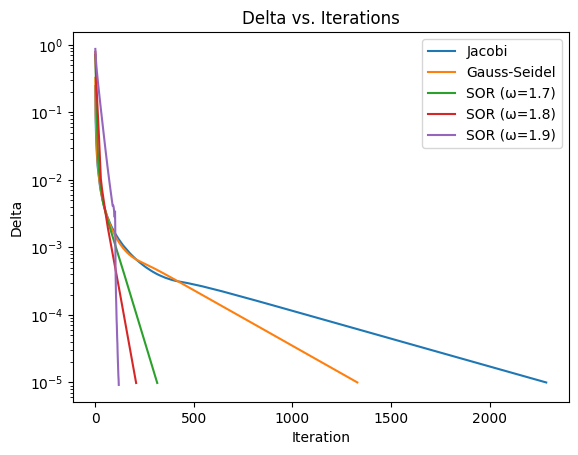

In [23]:
# Function to count iterations for each method
def track_delta(method, c, omega=None):
    deltas = []
    epsilon = 1e-5
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi(c)
        elif method == 'gs':
            c = gauss_seidel(c)
        elif method == 'sor':
            c = sor(c, omega)
        delta = np.max(np.abs(c_old - c))
        deltas.append(delta)
        iteration += 1
        if delta < epsilon:
            break
    return deltas

# Jacobi method
c = np.zeros((N+2, N+2))  
c[:, 0] = y  
c[:, -1] = y 
delta_jacobi = track_delta('jacobi', c.copy())

# Gauss-Seidel method 
c = np.zeros((N+2, N+2))  
c[:, 0] = y  
c[:, -1] = y 
delta_gs = track_delta('gs', c.copy())

# SOR method tested with many omega valces
omega_values = [1.7, 1.8, 1.9]
c = np.zeros((N+2, N+2))  
c[:, 0] = y  
c[:, -1] = y 
delta_sor = {omega: track_delta('sor', c.copy(), omega) for omega in omega_values}

# Plotting deltas against iterations
plt.plot(delta_jacobi, label='Jacobi')
plt.plot(delta_gs, label='Gauss-Seidel')
for omega, deltas in delta_sor.items():
    plt.plot(deltas, label=f'SOR (ω={omega})')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.title('Delta vs. Iterations')
plt.legend()
plt.show()


In [34]:
# Define grid sizes to test
grid_sizes = [20, 50, 100]  # Example grid sizes to see how ω changes with N
omega_range = np.linspace(1.7, 2.0, 16)  # Range of ω to test


# Function to find optimal ω for different grid sizes
# def omega_parameter(grid_sizes, omega_range):
optimal_omegas = {}
for N in grid_sizes:
    iterations_for_omegas = []
    for omega in omega_range:
        # Setup the grid and boundary conditions again for each N
        c = np.zeros((N+2, N+2))  
        y_list = np.linspace(0, 1, N+2)
        c[:, 0] = y_list  
        c[:, -1] = y_list 
        _, iterations = solve_laplace('sor', c.copy(), omega)
        iterations_for_omegas.append(iterations)
    
    # Omega with least iterations
    min_iterations = min(iterations_for_omegas)
    optimal_omega = omega_range[iterations_for_omegas.index(min_iterations)]
    optimal_omegas[N] = (optimal_omega, min_iterations)

    # return optimal_omegas

# Execute the function to find optimal ω for different grid sizes
# best_omega = omega_parameter(grid_sizes, omega_range)
# best_omega

KeyboardInterrupt: 